# EMA Study Shaps

John Curtin

## Set up environment

In [ ]:
# handle conflicts
options(conflicts.policy = "depends.ok")

library(tidyverse, quietly = TRUE)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## Get Local and Global SHAPs

In [ ]:
# shap_local_week <- read_rds(file.path(path_models, "outer_shaps_1week_0_v5_nested_main.rds")) 
# shap_local_day <- read_rds(file.path(path_models, "outer_shaps_1day_0_v5_nested_main.rds"))
# shap_local_hour <- read_rds(file.path(path_models, "outer_shaps_1hour_0_v5_nested_main.rds")) 
  
shap_local_week <- read_rds(file.path(path_models, "outer_shapsgrp_1week_0_v5_nested_main.rds")) 
shap_local_day <- read_rds(file.path(path_models, "outer_shapsgrp_1day_0_v5_nested_main.rds"))
shap_local_hour <- read_rds(file.path(path_models, "outer_shapsgrp_1hour_0_v5_nested_main.rds")) 

shap_global_week <- shap_local_week |> 
  group_by(variable_grp) |> 
  summarize(mean_value = mean(abs(value)), .groups = "drop") |> 
  arrange(mean_value)
shap_global_day <- shap_local_day |> 
  group_by(variable_grp) |> 
  summarize(mean_value = mean(abs(value)), .groups = "drop") |> 
  arrange(mean_value)
shap_global_hour <- shap_local_hour |> 
  group_by(variable_grp) |> 
  summarize(mean_value = mean(abs(value)), .groups = "drop") |> 
  arrange(mean_value)

shap_global_all <- shap_global_week |>
  mutate(window = "week") |>
  bind_rows(shap_global_day |>
              mutate(window = "day")) |>
  bind_rows(shap_global_hour |>
              mutate(window = "hour")) |>
  mutate(window = factor(window, levels = c("week", "day", "hour")))


## Global SHAP Plot

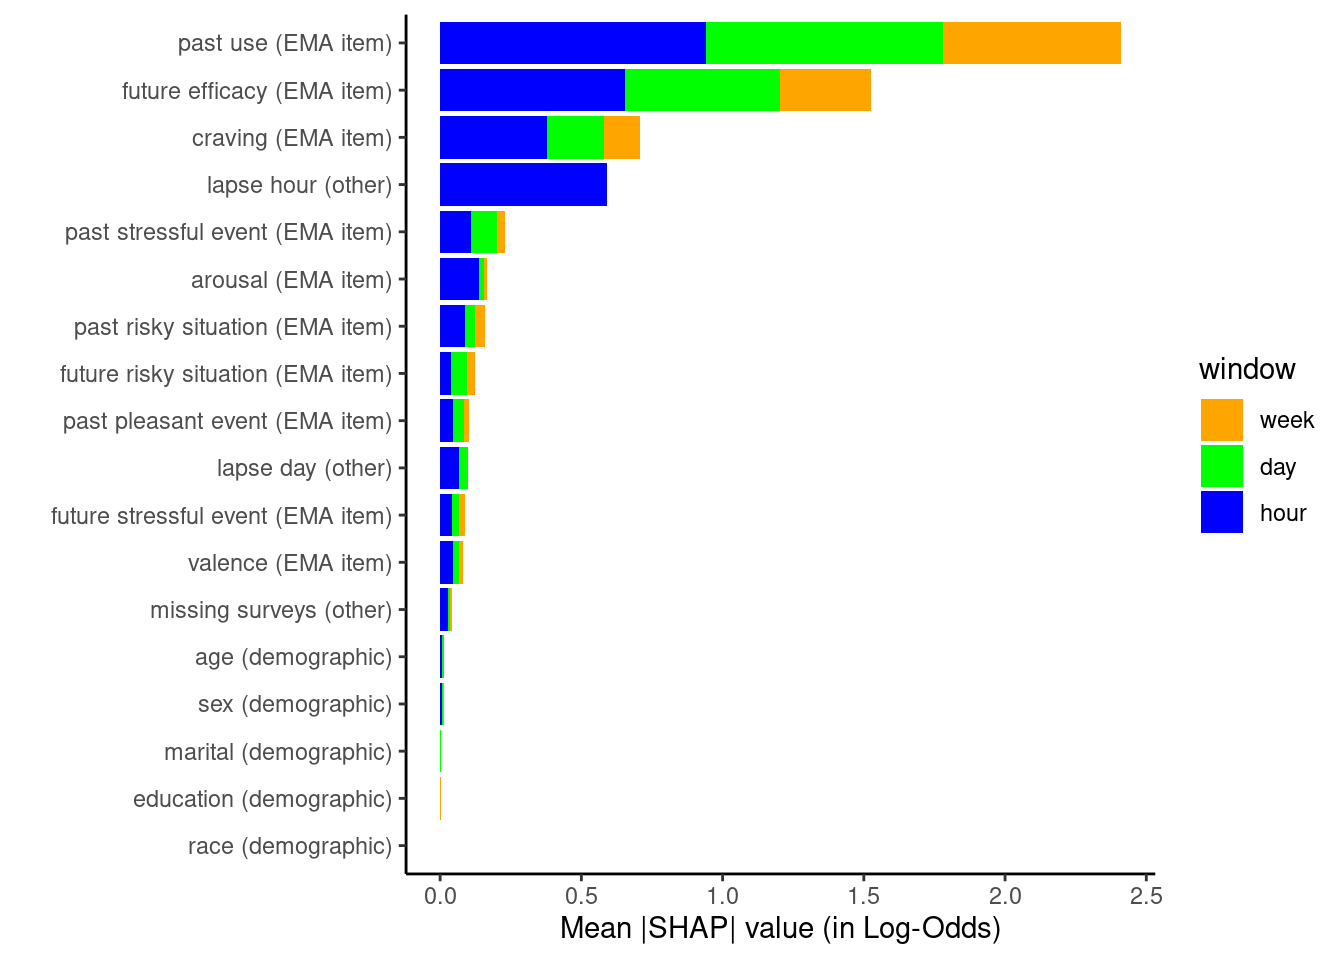

In [ ]:

shap_global_all |>
  mutate(group = reorder(variable_grp, mean_value, sum)) |>
  ggplot() +
  geom_bar(aes(x = group, y = mean_value, fill = window), stat = "identity") +
  ylab("Mean |SHAP| value (in Log-Odds)") +
  xlab("") +
  coord_flip() +
  scale_fill_manual(values = c("orange","green","blue"))


## Local Plot Function

In [ ]:
plot_local <- function(shaps, grp_levels, ids, model){
  bar_color <- 
    case_when(
      tolower(model) == "week" ~ "orange",
      tolower(model) == "day" ~ "green",
      tolower(model) == "hour" ~ "blue",
    )
  
  shaps |> 
    filter(id_obs %in% ids) |>
    mutate(group = factor(variable_grp, levels = grp_levels)) |>
    ggplot(mapping = aes(x = group, y = value)) +
    ggforce::geom_sina(method = "counts", maxwidth = 0.7, alpha = 0.4,
                       color = bar_color) +
    geom_hline(yintercept = 0) +
    scale_y_continuous(limits = c(-2, 5), breaks = seq(-2, 5)) +
    ylab("SHAP value (in Log-Odds)") +
    xlab("") +
    coord_flip() 
    # ggtitle(model)
}


## Local SHAP Plots

Get feature order and ids for downsample

In [ ]:
# get order for items based on global sum importance
grp_levels <- shap_global_all |>
  mutate(variable_grp = reorder(variable_grp, mean_value, sum)) |>
  pull(variable_grp) |>
  levels()

# downsample to 2% of observations for each plot
ids_week <- shap_local_week |>
  pull(id_obs) |>
  unique()
ids_week <- ids_week |> sample(size = round(length(ids_week)/50))

ids_day <- shap_local_day |>
  pull(id_obs) |>
  unique()
ids_day <- ids_day |> sample(size = round(length(ids_day)/50))

ids_hour <- shap_local_hour |>
  pull(id_obs) |>
  unique()
ids_hour <- ids_hour |> sample(size = round(length(ids_hour)/50))


Week Plot

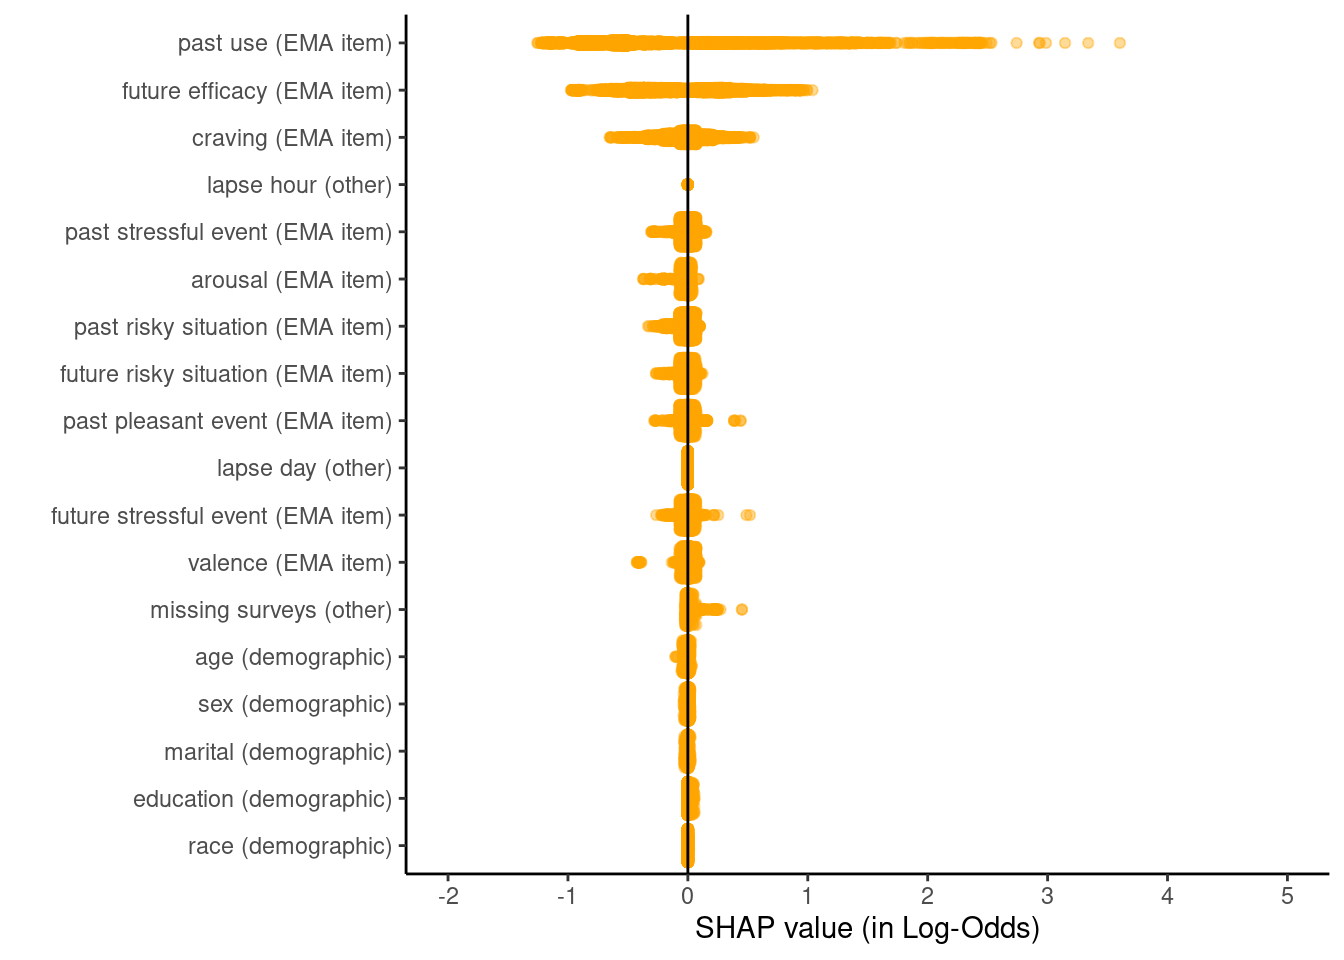

In [ ]:

shap_local_week |>
  plot_local(grp_levels, ids_week, "Week")


Day plot

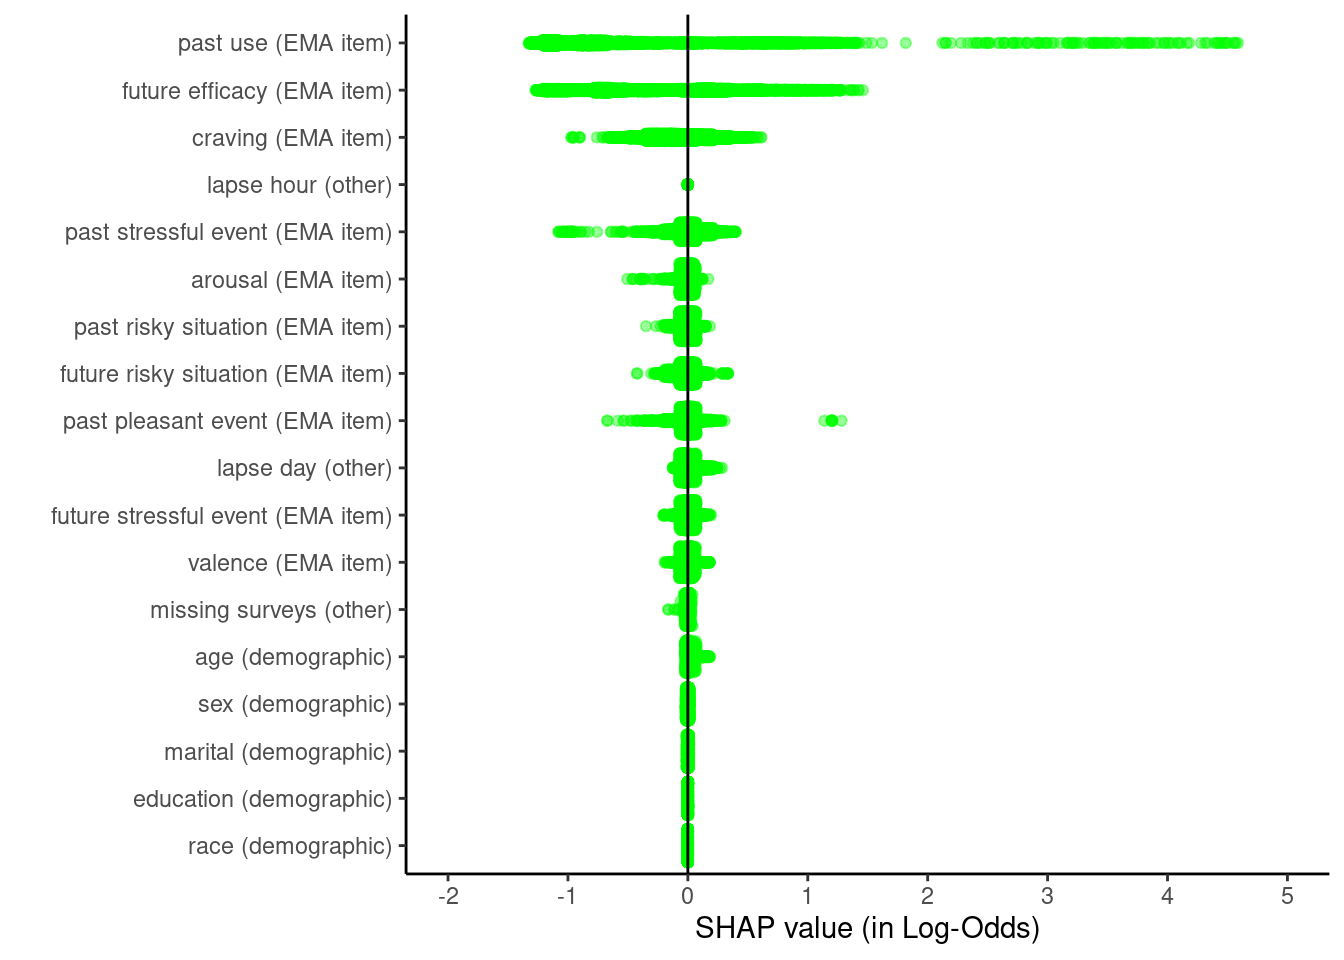

In [ ]:

shap_local_day |>
  plot_local(grp_levels, ids_day, "Day")


Hour plot

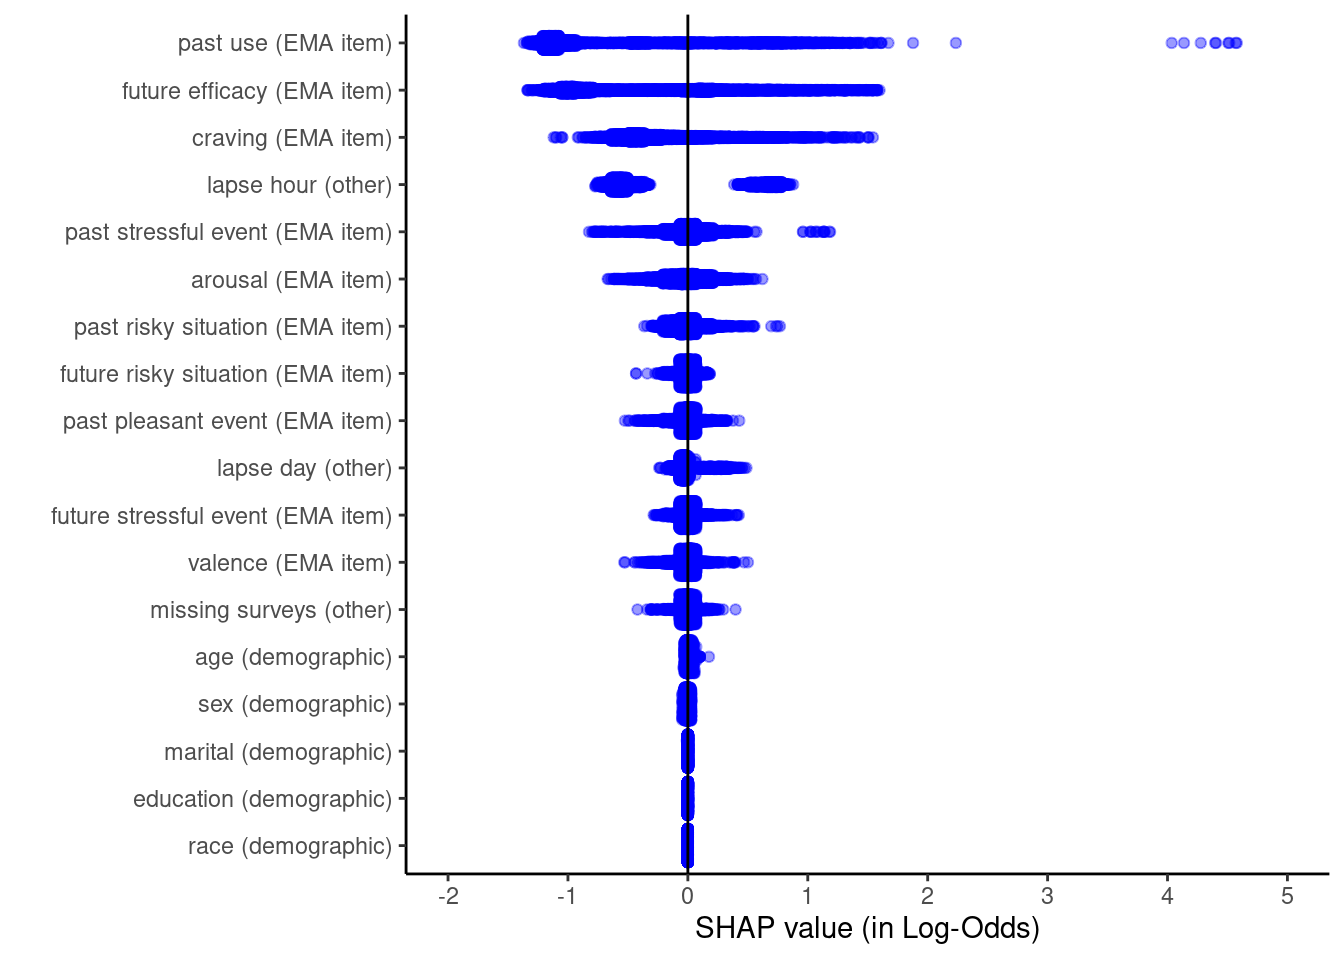

In [ ]:

shap_local_hour |>
  plot_local(grp_levels, ids_hour, "Hour")
